# DRILL: Prepare the Data

Unit 2: Lesson 4: 2

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

$$ Property crime = \alpha + \beta_{1}*Population + \beta_{2}*Population^2 + \beta_{3}*Murder + \beta_{4}*Robbery$$

The 'population' variable is already set for you, but you will need to create the last three features.  Robbery and Murder are currently continuous variables.  For this model, please use these variables to create  categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0.  You'll use this data and model in a later assignment- for now, just write the code you need to get the data ready.  Don't forget basic data cleaning procedures, either!  Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.

In [38]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [13]:
crime = pd.read_excel('crime_NYC.xls', header=None)
# First 4 lines are descriptions
crime.drop(crime.index[0:4], inplace=True)
# Now set first row to column headers and drop that row
crime.columns = crime.iloc[0]
crime.drop(crime.index[0], inplace=True)


In [14]:
crime.head()

4,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
5,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0
6,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0
7,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0
8,Albany,97956,791,8,NaN,30,227,526,4090,705,3243,142,NaN
9,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN


In [25]:
columnlist = crime.columns
print(columnlist)

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object', name=4)


In [30]:
# Rename murder column
crime.rename(columns={'Murder and\nnonnegligent\nmanslaughter':'Murder', 'Property\ncrime': 'PropertyCrime'}, inplace=True)

crime.columns
print(crime['Murder'].isnull().sum())
print(crime['Robbery'].isnull().sum())
print(crime['PropertyCrime'].isnull().sum())

3
3
3


In [36]:
# Drop NaN - might be all three if I'm lucky
crime.dropna(subset=['PropertyCrime'], inplace=True)
print(crime['Murder'].isnull().sum())
print(crime['Robbery'].isnull().sum())
print(crime['PropertyCrime'].isnull().sum())

0
0
0


In [37]:
# Robbery and Murder are currently continuous variables.  
# Rework murder and robbery into dummies (values greater than 0 are coded 1)
# Going to lose NaN for 0 here... not sure how to fix this? Can drop NaN beforehand
crime['Robbery_dummy'] = crime['Robbery'].apply(lambda x: 1 if x>0 else 0)
print(crime['Robbery_dummy'].isnull().sum())
crime['Murder_dummy'] = crime['Robbery'].apply(lambda x: 1 if x>0 else 0)
print(crime['Murder_dummy'].isnull().sum())

# Population squared
crime['Pop2'] = crime['Population']*crime['Population']



0
0


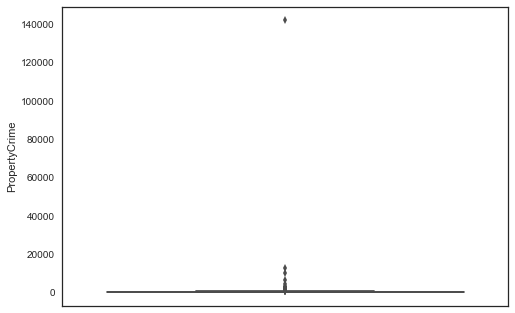

In [42]:
# Looking for outliers
sns.set(style='white')
sns.boxplot(y='PropertyCrime', data=crime)
plt.show()

In [43]:
# There's only one place big enough for that kind of outlier
crime.loc[crime['PropertyCrime']>120000,:]

4,City,Population,Violent crime,Murder,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,PropertyCrime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Robbery_dummy,Murder_dummy
221,New York,8396126,52384,335,NaN,1112,19170,31767,141971,16606,117931,7434,NaN,1,1


TypeError: No loop matching the specified signature and casting
was found for ufunc svd_n_s

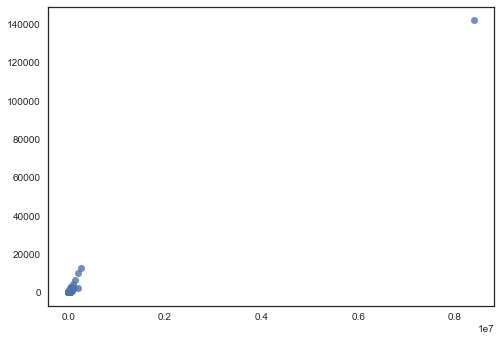

In [45]:
sns.regplot(x='Population', y='PropertyCrime', data=crime, scatter=True)
plt.show()

**NYC will definitely affect the regression models**

The best way to deal with this is to rework all the variables into crimes per capita. Here this isn't possible as the model explicitly wants to include population (and population squared, which will give it even more weight!).

Given that per capita is ruled out there are two options:
1. Dropping NYC observation leads to a large loss of information (it accounts for more than 90% of crime observations). This is possible as long as it is explicitly stated that it does not include NYC.
2. Square root or log transformation. In this case the size of the NYC outlier means that the outlier will still have a large weight.
3. Keep the model as it is. Explaining the one datapoint (NYC) basically means that you can predict all crime in NY state.

Proposed solution: Two models, one with NYC and one without and then can compare betas.